<a href="https://colab.research.google.com/github/yongghongg/stock-screener/blob/main/supertrend_demo_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt

In [11]:
def Supertrend(df, atr_period, multiplier):
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    # df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    
    
atr_period = 10
atr_multiplier = 3.0

stock_list = ['AAPL']
for symbol in stock_list:
    df = yf.download(symbol, start='2020-01-01')
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    df = df.join(supertrend)
df.tail(15)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Supertrend,Final Lowerband,Final Upperband
Date,,,,,,,,,
2021-09-03,153.759995,154.630005,153.089996,154.300003,154.300003,57808700,True,146.415050,NaN
2021-09-07,154.970001,157.259995,154.389999,156.690002,156.690002,82278300,True,148.236544,NaN
2021-09-08,156.979996,157.039993,153.979996,155.110001,155.110001,74420200,True,148.236544,NaN
2021-09-09,155.490005,156.110001,153.949997,154.070007,154.070007,57305700,True,148.236544,NaN
2021-09-10,155.000000,155.479996,148.699997,148.970001,148.970001,140646400,True,148.236544,NaN
2021-09-13,150.630005,151.419998,148.750000,149.550003,149.550003,102404300,True,148.236544,NaN
2021-09-14,150.350006,151.070007,146.910004,148.119995,148.119995,109296300,False,NaN,158.162043
2021-09-15,148.559998,149.440002,146.369995,149.029999,149.029999,83281300,False,NaN,157.080835
2021-09-16,148.440002,148.970001,147.220001,148.789993,148.789993,68034100,False,NaN,156.896253


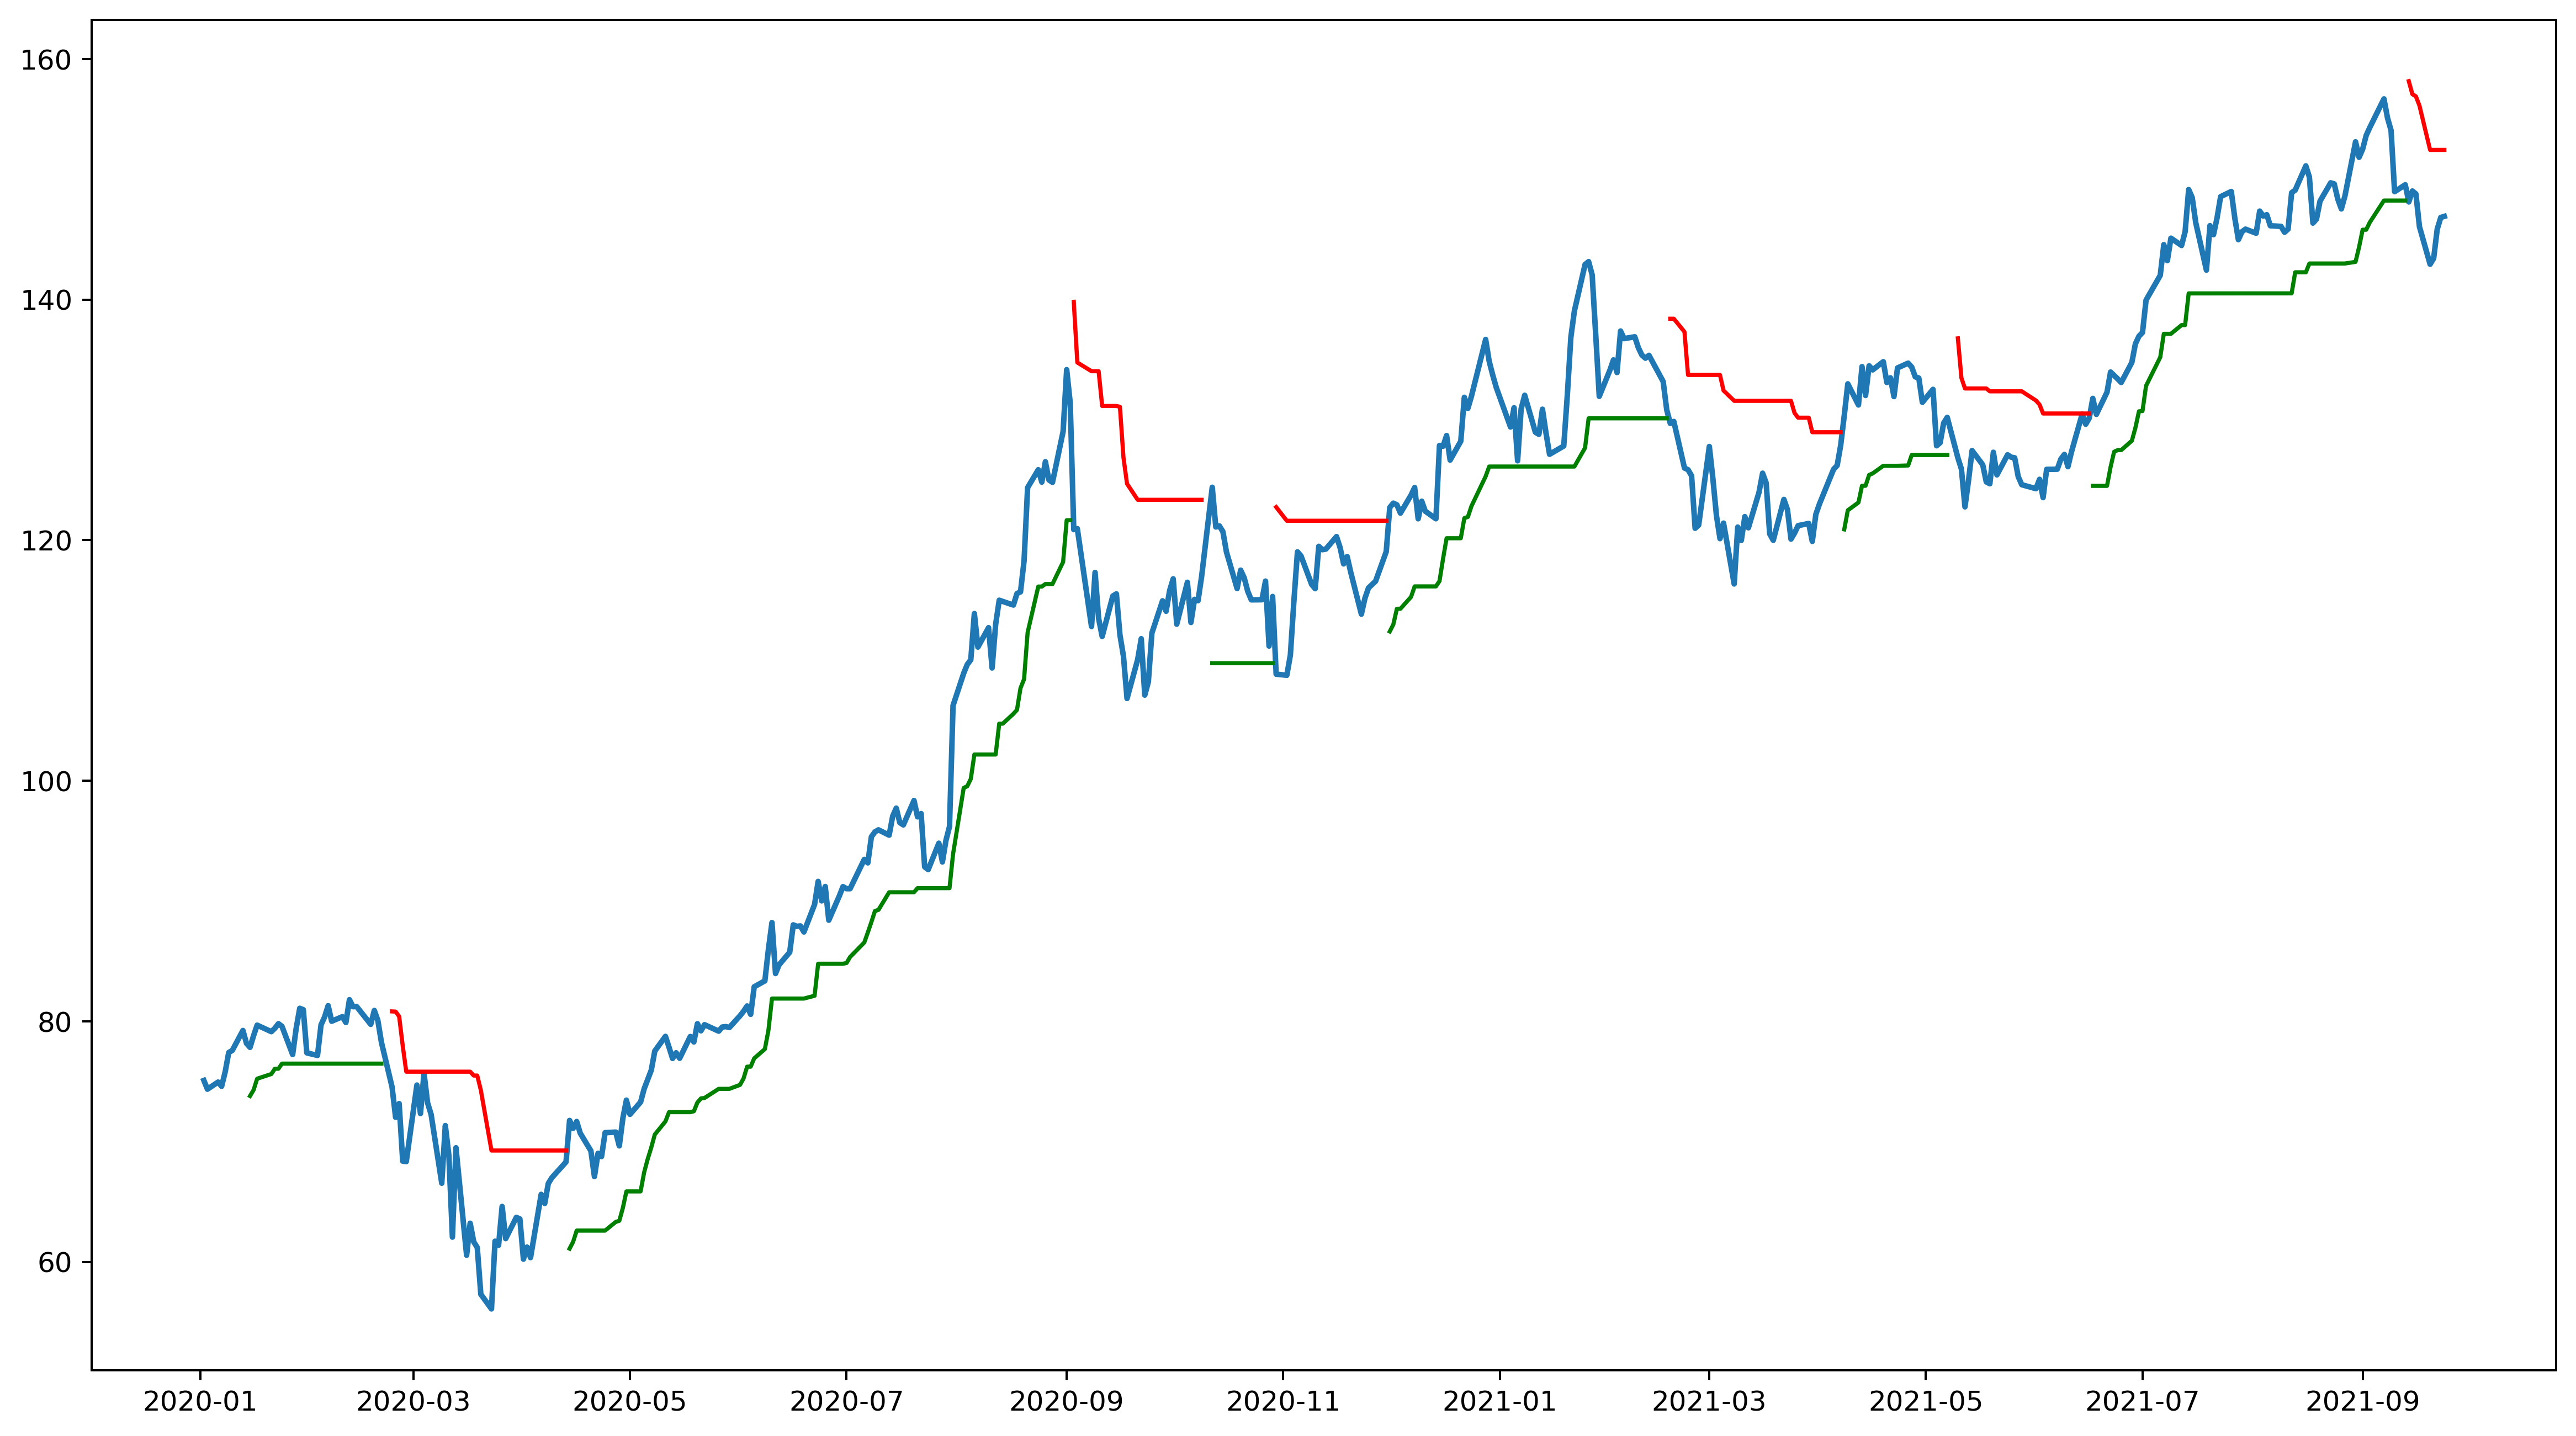

In [5]:
# visualization
plt.figure(figsize=(16,9),dpi=360)
plt.plot(df['Close'], linewidth = 2, label='Close Price')
plt.plot(df['Final Lowerband'],'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.show()

In [12]:
# backtesting

def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend']
    close = df['Close']
    
    # initial condition
    in_position = False
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []
    
    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position and is_uptrend[i]:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
#             print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
        # if in position & price is not on uptrend -> sell
        elif in_position and not is_uptrend[i]:
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
#             print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
    # if still in position -> sell all share 
    if in_position:
        equity += share * close[i] - commission
    
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')
    return entry, exit, roi
entry, exit, roi = backtest_supertrend(df, 100000)

Earning from investing $100k is $64885.26 (ROI = 64.89%)


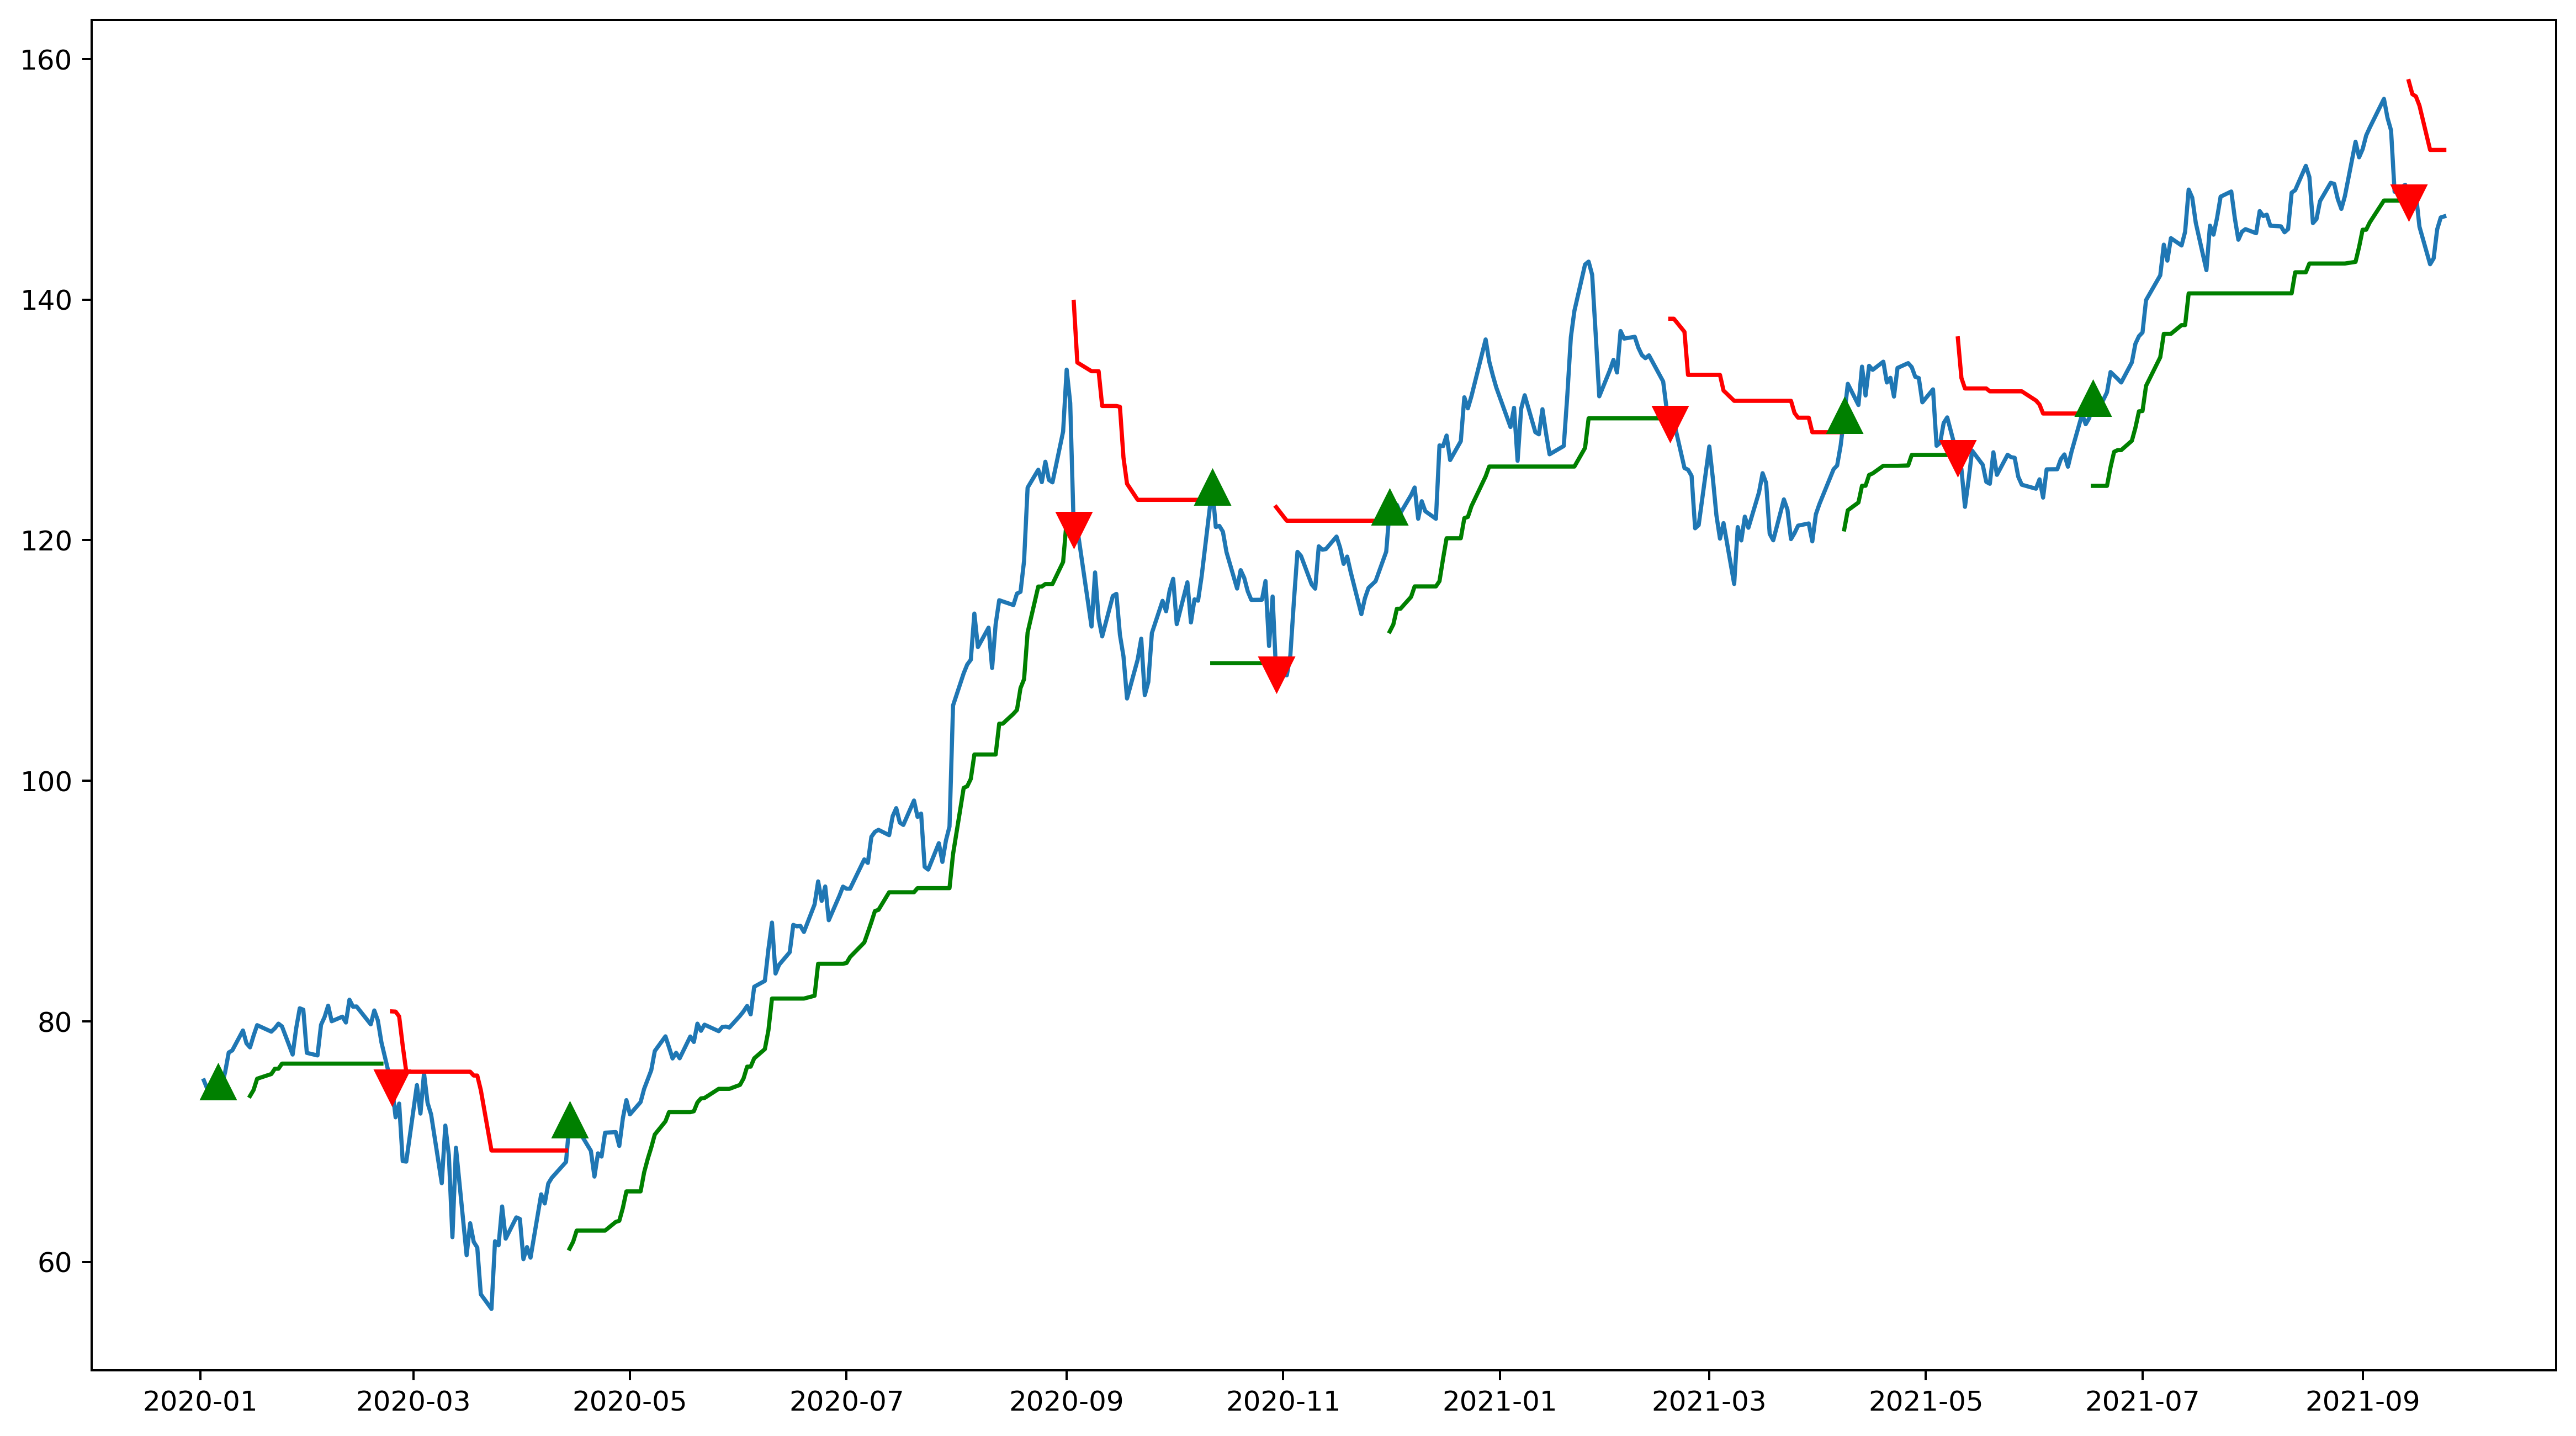

In [13]:
# visualization (for backtest)

plt.figure(figsize=(16,9),dpi=360)
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Final Lowerband'],'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
for e in entry:
    plt.plot(df.index[e[0]], e[1], marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'Entry')
for e in exit:
    plt.plot(df.index[e[0]], e[1], marker = 'v', color = 'red', markersize = 12, linewidth = 0, label = 'Exit')
plt.show()

In [ ]:
# get the full stock list of S&P 500
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stock_list = payload[0]['Symbol'].values.tolist()

supertrend_stocks = []
# loop through each symbol
for symbol in stock_list:
    df = yf.download(symbol, start='2010-01-01', threads= False)
    if len(df) == 0: continue
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    if not supertrend['Supertrend'][-2] and supertrend['Supertrend'][-1]:
        supertrend_stocks.append(symbol)

In [ ]:
for s in supertrend_stocks:
    print(s, end=', ')

AAL, APH, BAC, CDAY, CME, DFS, F, JPM, MTB, MA, PBCT, RJF, RTX, RF, TFC, UAL, V, VNO, ZBH, 

In [14]:
# BONUS: parameter optimization
def find_optimal_parameter(df):
    # predefine several parameter sets
    atr_period = [7, 8, 9, 10]
    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0]

    roi_list = []
    
    # for each period and multiplier, perform backtest
    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:
        new_df = df
        supertrend = Supertrend(df, period, multiplier)
        new_df = df.join(supertrend)
        new_df = new_df[period:]
        entry, exit, roi = backtest_supertrend(new_df, 100000)
        roi_list.append((period, multiplier, roi))
    
    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))
    
    # return the best parameter set
    return max(roi_list, key=lambda x:x[2])

df = yf.download('TSLA', start='2010-01-01')
optimal_param = find_optimal_parameter(df)

print(f'Best parameter set: ATR Period={optimal_param[0]}, Multiplier={optimal_param[1]}, ROI={optimal_param[2]}')

[*********************100%***********************]  1 of 1 completed
Earning from investing $100k is $1050660.1 (ROI = 1050.66%)
Earning from investing $100k is $1018779.64 (ROI = 1018.78%)
Earning from investing $100k is $1499493.81 (ROI = 1499.49%)
Earning from investing $100k is $4130723.37 (ROI = 4130.72%)
Earning from investing $100k is $2128485.37 (ROI = 2128.49%)
Earning from investing $100k is $756177.49 (ROI = 756.18%)
Earning from investing $100k is $751944.3 (ROI = 751.94%)
Earning from investing $100k is $1455534.41 (ROI = 1455.53%)
Earning from investing $100k is $3160668.04 (ROI = 3160.67%)
Earning from investing $100k is $2072028.78 (ROI = 2072.03%)
Earning from investing $100k is $690536.51 (ROI = 690.54%)
Earning from investing $100k is $785929.31 (ROI = 785.93%)
Earning from investing $100k is $1295848.58 (ROI = 1295.85%)
Earning from investing $100k is $2519305.75 (ROI = 2519.31%)
Earning from investing $100k is $2433758.36 (ROI = 2433.76%)
Earning from investing $10